# **2. 기상시간 예측하기**

** 일 단위의 사용자 기상 시간 데이터를 이용하여 다음 기상 시간을 예측한다**

In [192]:
## 라이브러리 import

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [193]:
## 데이터 불러오기

df = pd.read_csv('./nodate.csv', error_bad_lines=False) 
df.head()

,wake_time,sleep_second
0,7:10,25800
1,7:00,25200
2,7:00,25200
3,5:40,20400
4,7:30,27000


---------------

## **데이터 확인 및 전처리**

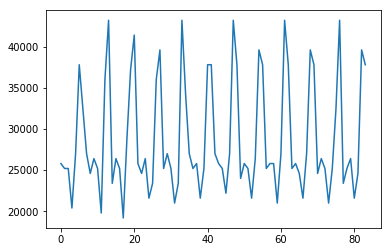

In [194]:
## 시각화 -> 시계열 형태 확인

df['sleep_second'].plot()

In [195]:
# 0~55(56일): 학습, 56~69(14일): 검증, 70~83(14일): 테스트

train = df.loc[:56, ['sleep_second']]
val = df.loc[56:70, ['sleep_second']]
test = df.loc[70:, ['sleep_second']]

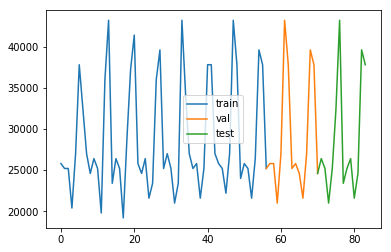

In [196]:
## 다시 시각화

ax = train.plot()
val.plot(ax=ax)
test.plot(ax=ax)
plt.legend(['train','val', 'test'])

In [197]:
## 0~1 사이 값으로 스케일링 하기
## MinMaxScaler 사용 -> 참고: https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test) # train 스케일 할 때 fit 해준 분포 그대로 가져와야 하기 때문에 transform만 해주기

In [198]:
## df로 바꾸기
train = pd.DataFrame(scaled_train, columns=['sleep_second'], index=train.index)
val = pd.DataFrame(scaled_val, columns=['sleep_second'], index=val.index)
test= pd.DataFrame(scaled_test, columns=['sleep_second'], index=test.index)

In [199]:
## window(LSTM 훈련 단위)를 7로 설정하고 shift()로 window 크기만큼 데이터만 이동 시키기

for s in range(1, 8):
    train['shift_{}'.format(s)] = train['sleep_second'].shift(s)
    val['shift_{}'.format(s)] = val['sleep_second'].shift(s)
    test['shift_{}'.format(s)] = test['sleep_second'].shift(s)

test.head(8)

,sleep_second,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
70,0.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,0.300,0.225,NaN,NaN,NaN,NaN,NaN,NaN
72,0.250,0.300,0.225,NaN,NaN,NaN,NaN,NaN
73,0.075,0.250,0.300,0.225,NaN,NaN,NaN,NaN
74,0.250,0.075,0.250,0.300,0.225,NaN,NaN,NaN
75,0.550,0.250,0.075,0.250,0.300,0.225,NaN,NaN
76,1.000,0.550,0.250,0.075,0.250,0.300,0.225,NaN
77,0.175,1.000,0.550,0.250,0.075,0.250,0.300,0.225


In [200]:
## null값 제거 + 독립변수/종속변수 나누기

X_train = train.dropna().drop('sleep_second', axis=1)
y_train = train.dropna()[['sleep_second']]
X_val = val.dropna().drop('sleep_second', axis=1)
y_val = val.dropna()[['sleep_second']]
X_test = test.dropna().drop('sleep_second', axis=1)
y_test = test.dropna()[['sleep_second']]

In [201]:
X_val.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
63,0.775,1.000,0.325,0.075,0.275,0.275,0.250
64,0.250,0.775,1.000,0.325,0.075,0.275,0.275
65,0.275,0.250,0.775,1.000,0.325,0.075,0.275
66,0.225,0.275,0.250,0.775,1.000,0.325,0.075
67,0.100,0.225,0.275,0.250,0.775,1.000,0.325


In [202]:
## 분석할 때 numpy ndarray 써야되니까 values로 바꾸기

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values


In [203]:
## Keras LSTM 이용하려면 3차원 변환 필요 -> (데이터 수, slot 수, feature 수)

## (데이터 수, slot 수) 확인 먼저 해보기
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(50, 7)
(50, 1)
(8, 7)
(8, 1)


In [204]:
## reshape 하기 
X_train_t = X_train.reshape(X_train.shape[0], 7, 1)
X_val_t = X_val.reshape(X_val.shape[0], 7, 1)
X_test_t = X_test.reshape(X_test.shape[0], 7, 1)



print(X_train_t.shape)
print(X_test_t.shape)

(50, 7, 1)
(7, 7, 1)


--------------

## **학습 수행**

In [205]:
## LSTM 모델 만들기 -> Keras 사용

import keras
from keras.layers import LSTM 
from keras.models import Sequential # 레이어를 선형으로 쌓는 모델
from keras.layers import Dense # 완전 연결 레이어
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 객체 
model.add(LSTM(40, input_shape=(7, 1)))# (slot 수, feature 수) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) 
model.summary() # 모델 내용 확인

#loss: 'binary_crossentropy', 'mean_squared_error'
#optimizer: adam, sgd, RMSprop, Adagrad
#activation: sigmoid, relu , softmax

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [206]:
## fit

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1) 

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop], validation_data=(X_val_t, y_val))

Train on 50 samples, validate on 8 samples
Epoch 1/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.0200 - val_loss: 0.0780 - val_accuracy: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 0s 298us/step - loss: 0.0882 - accuracy: 0.0200 - val_loss: 0.0760 - val_accuracy: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 0s 339us/step - loss: 0.0864 - accuracy: 0.0200 - val_loss: 0.0742 - val_accuracy: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 0s 279us/step - loss: 0.0853 - accuracy: 0.0200 - val_loss: 0.0726 - val_accuracy: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 0s 319us/step - loss: 0.0838 - accuracy: 0.0200 - val_loss: 0.0712 - val_accuracy: 0.0000e+00
Epoch 6/100
50/50 [==============================] - 0s 279us/step - loss: 0.0828 - accuracy: 0.0200 - val_loss: 0.0699 - val_accuracy: 0.0000e+00
Epoch 7/100
50/50 [==============================] - 0s 299us/step - loss: 0.

----------------

## **예측 수행 및 평가**

In [207]:
## 테스트 데이터로 예측

y_pred = model.predict(X_test_t, batch_size=30)

y_pred

array([[0.33892703],
       [0.22721007],
       [0.1555824 ],
       [0.17901939],
       [0.29115552],
       [0.6629264 ],
       [0.76847297]], dtype=float32)

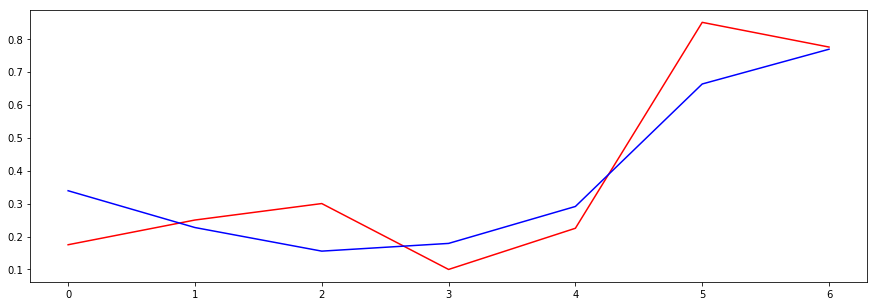

In [208]:
plt.figure(figsize=(15,5))

plt.plot(y_test, color='red', label='true')
plt.plot(y_pred, color='blue', label='pred')

In [209]:
eval_ = model.evaluate(X_test_t, y_test, batch_size=30)
eval_

7/7 [==============================] - 0s 285us/step


[0.0134153813123703, 0.0]